Updating data................

YahooFinance("BIIB") has dubious total open-to-open returns for timestamps: DatetimeIndex(['2005-02-25 14:30:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)


.....................................................................................
iteration 0
Current objective:
0.5741975411767973
iteration 1
Current objective:
0.592204945768526
iteration 2
Current objective:
0.603107845198526
iteration 3
Current objective:
0.6136592039834774
iteration 4
Current objective:
0.6272848217313346
iteration 5
Current objective:
0.6369090433434016
iteration 6
Current objective:
0.6420724175390867
iteration 7
Current objective:
0.646380919452454
iteration 8
Current objective:
0.6520254628992201
iteration 9
Current objective:
0.6556892859790406
iteration 10
Current objective:
0.6608586745621609
iteration 11
Current objective:
0.6660513110507005
iteration 12
Current objective:
0.6695708374227731
iteration 13
Current objective:
0.6695762547895345
iteration 14
Current objective:
0.669638836861805
iteration 15
Current objective:
0.6696421399358968
Optimized policy hyper-parameters:
SinglePeriodOptimization(objective=ReturnsForecast(r_hat=HistoricalMeanReturn

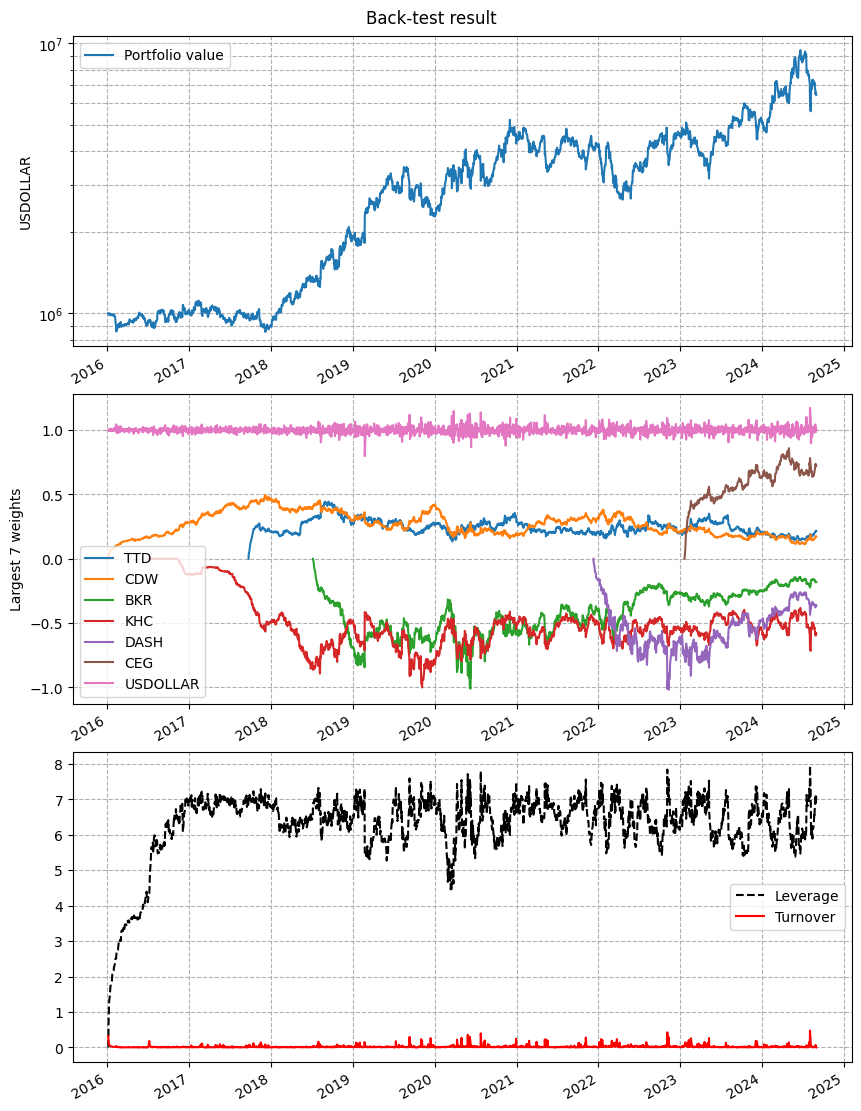

In [1]:
import numpy as np

import cvxportfolio as cvx

from universes import NDX100 as UNIVERSE

# times
START = '2016-01-01'
END = None # today

# Currently (~2024) shorting large cap US stocks costs about this,
# in annualized percentages
BORROW_FEES = 0.25

# We set the bid-ask spreads at 5 basis points
SPREAD = 5E-4

# This is the b multiplier of the (3/2) power term in TransactionCost
MARKET_IMPACT = 1.

policy = cvx.SinglePeriodOptimization(
    objective=cvx.ReturnsForecast()
        - cvx.Gamma() * cvx.FactorModelCovariance(num_factors=10)
        - cvx.Gamma() * cvx.TransactionCost(a=SPREAD/2, b=MARKET_IMPACT)
        - cvx.Gamma() * cvx.HoldingCost(short_fees=BORROW_FEES),
    constraints = [
        cvx.DollarNeutral(), cvx.MarketNeutral(), cvx.LeverageLimit(7)],
    # this solver is somewhat more robust than ECOS, but less efficient
    solver='CLARABEL',
    # this is a CVXPY compilation flag that disables a feature that is very
    # useful (cache a semi-compiled problem) but its implementation scales
    # badly with the problem size; if you increase number of factors or
    # universe size, you may have to uncomment the next line
    # ignore_dpp=True,
)

simulator = cvx.MarketSimulator(
    universe=UNIVERSE,
    costs = [
        cvx.TransactionCost(a=SPREAD/2, b=MARKET_IMPACT),
        cvx.HoldingCost(short_fees=BORROW_FEES)])

# automatic hyper-parameter optimization (by greedy grid search)
simulator.optimize_hyperparameters(
    policy, start_time=START, end_time=END,
    objective='sharpe_ratio')

print('Optimized policy hyper-parameters:')
print(policy)

# back-test the policy with optimized hyper-parameters
result = simulator.backtest(policy, start_time=START, end_time=END)

print("Optimized policy back-test result:")
print(result)

# plot
result_figure = result.plot()

# check that back-tested returns of the strategy are uncorrelated with the
# market benchmark
market_benchmark_returns = simulator.backtest(
    cvx.MarketBenchmark(), start_time=START, end_time=END).returns

print('Correlation of strategy returns with benchmark:')
print(np.corrcoef(result.returns, market_benchmark_returns)[0, 1])